<a href="https://colab.research.google.com/github/gauravdaga06/Machine-Learning/blob/master/Building_an_Image_Classifier_Using_the_Keras_Sequential_API_%26_with_Dataset_fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:,2:]        #taking lenght and width column
y = (iris.target ==0)         #selecting Iris Sentosa

per_clf = Perceptron()
per_clf.fit(X,y)

y_pred = per_clf.predict([[2, 0.5]])

print(y_pred)                  #output will be true or false whether the given features are of Iris Sentosa or not

[False]


**Activation functions**

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Unrecognized location 'Top Left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


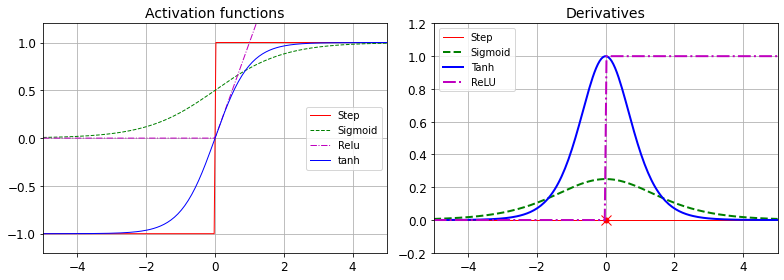

In [4]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z,sigmoid(z),"g--", linewidth=1, label="Sigmoid")
plt.plot(z,relu(z),"m-.", linewidth=1, label="Relu")
plt.plot(z,np.tanh(z),"b-", linewidth=1, label="tanh")

plt.grid(b=True, which='major', axis='both')
plt.legend(loc ="center right")

plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])



plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="Top Left", fontsize=10)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])


save_fig("activation_functions_plot")
plt.show()

In [5]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

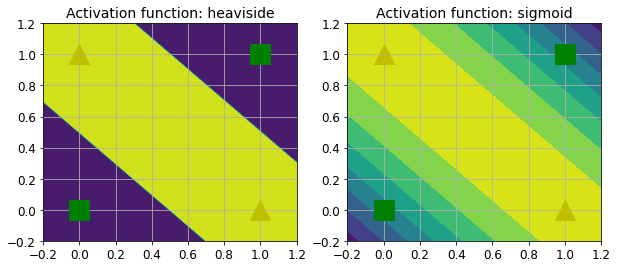

In [6]:

x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

**Building an Image Classifier**

importing datasets

In [7]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [8]:
from tensorflow import keras
keras.__version__

'2.4.0'

In [9]:
fashion_mnist =keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [10]:
X_train_full.shape,X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

In [11]:
X_test.shape,X_test.dtype

((10000, 28, 28), dtype('uint8'))

These means We have Divided the fashion MNIST dataset into 2 parts training and testing as  Training: 60,000,Testing: 10,000

Additionally, since we are going to train the neural network using Gradient Descent, we must scale the input features. For simplicity.

Scalling the Dataset

In [12]:
X_valid,X_train =X_train_full[:5000]/255.0 ,X_train_full[5000:]/255.0
y_valid,y_train =y_train_full[:5000],y_train_full[5000:]

X_test = X_test/255

In [13]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

'Coat'

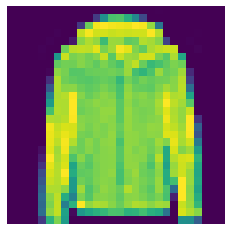

In [14]:

plt.imshow(X_train[0])
plt.axis('off')

class_names[y_train[0]]


In [15]:
y_valid.shape

(5000,)

In [16]:
y_valid

array([9, 0, 0, ..., 5, 8, 3], dtype=uint8)

Saving figure fashion_mnist_plot


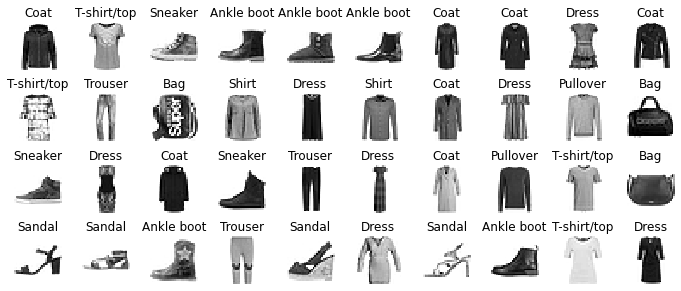

In [17]:
rows=4
cols = 10
plt.figure(figsize=(cols * 1.2, rows * 1.2))

for row in range(rows):
  for col in range(cols):
    index = cols*row+col
    plt.subplot(rows,cols, index + 1)
    plt.imshow(X_train[index],cmap="binary", interpolation="nearest")
    plt.axis('off')
    
    plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(10,activation="softmax"))

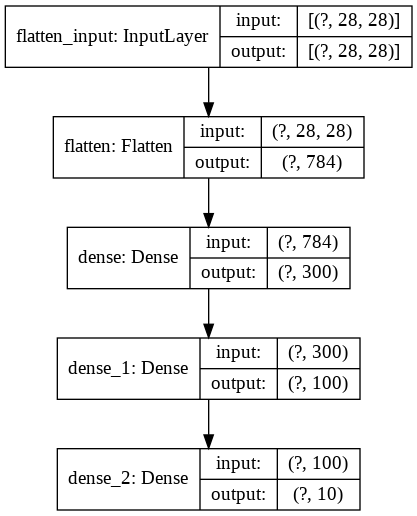

In [19]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note that Dense layers often have a lot of parameters. For example, the first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters
This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data.






In [21]:
model.layers      #getting list of Layers

In [22]:
print(model.layers[1])
print(model.layers[1].name)

dense


In [23]:
hidden1 = model.layers[1]

In [24]:
hidden1.name

'dense'

In [25]:
weights,biases =hidden1.get_weights()

In [26]:
print(weights)
print(weights.shape)

[[ 0.07232748 -0.04555056 -0.05905041 ...  0.00591171  0.01020024
   0.0237498 ]
 [ 0.04829509  0.0596489  -0.05889783 ...  0.02697727 -0.05764695
   0.07045723]
 [ 0.0667295   0.05643842  0.07013848 ... -0.00887565 -0.02303008
  -0.05695267]
 ...
 [ 0.06390277 -0.04783479 -0.05801734 ...  0.0722091   0.01609776
  -0.05669204]
 [-0.06809802  0.03941449  0.0453582  ...  0.07215968 -0.06763424
  -0.02400077]
 [ 0.01894495  0.05703025  0.06286527 ...  0.00675698 -0.01423967
   0.02180855]]
(784, 300)


In [27]:
print(biases)
print(biases.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(300,)


In [28]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

sparse_categorical_cross entropy" loss because we have Scattered Lables.      
And We have Used SoftMax because We Have to classify the items into n number of categories.   
Regarding the optimizer, "sgd" means that we will train the model using simple Stochastic Gradient Descent

In [29]:
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7159 - accuracy: 0.7677 - val_loss: 0.5069 - val_accuracy: 0.8356
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4897 - accuracy: 0.8301 - val_loss: 0.4783 - val_accuracy: 0.8436
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4451 - accuracy: 0.8450 - val_loss: 0.4218 - val_accuracy: 0.8558
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4151 - accuracy: 0.8554 - val_loss: 0.3947 - val_accuracy: 0.8618
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3949 - accuracy: 0.8615 - val_loss: 0.3944 - val_accuracy: 0.8592
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3781 - accuracy: 0.8665 - val_loss: 0.3701 - val_accuracy: 0.8740
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3659 - accuracy: 0.8704 - val_loss: 0.3724 - val_accuracy:

In [30]:
history.history

{'accuracy': [0.7677454352378845,
  0.8301454782485962,
  0.8449817895889282,
  0.8554182052612305,
  0.8615454435348511,
  0.8664727210998535,
  0.8703818321228027,
  0.8758545517921448,
  0.8770363926887512,
  0.8816909193992615,
  0.8833272457122803,
  0.8863818049430847,
  0.8876545429229736,
  0.8900908827781677,
  0.8923272490501404,
  0.8954908847808838,
  0.8964181542396545,
  0.8992363810539246,
  0.90052729845047,
  0.9021636247634888,
  0.9051818251609802,
  0.9058363437652588,
  0.9074727296829224,
  0.9092000126838684,
  0.9110545516014099,
  0.9119818210601807,
  0.9139999747276306,
  0.9154363870620728,
  0.9167272448539734,
  0.9177818298339844],
 'loss': [0.7159072160720825,
  0.4896719455718994,
  0.4450939893722534,
  0.4151242673397064,
  0.3948867917060852,
  0.37805888056755066,
  0.36593934893608093,
  0.3548036217689514,
  0.3442942202091217,
  0.3352419137954712,
  0.32667577266693115,
  0.31886622309684753,
  0.311596155166626,
  0.3049572706222534,
  0.298147

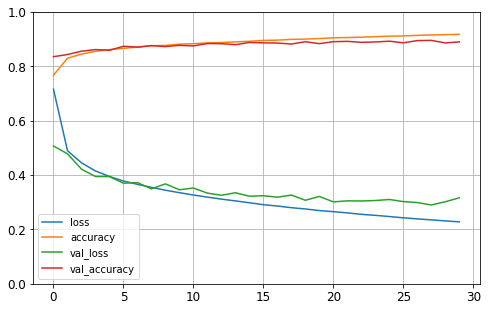

In [31]:
pd.DataFrame(history.history).plot(figsize = (8,5))      #here is the main for plot
plt.grid(True)
plt.gca().set_ylim(0,1)        #Set vertical range (0,1)
plt.show()

In [32]:
history.params

{'epochs': 30, 'steps': 1719, 'verbose': 1}

In [33]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 0s 2ms/step - loss: 0.3428 - accuracy: 0.8784


[0.34276437759399414, 0.8784000277519226]

Since we don’t have actual new instances, we will just use the first three instances of the test set

In [34]:
X_new = X_test[:3]
y_prob = model.predict(X_new)


In [36]:
y_prob

array([[1.37659652e-06, 2.82682549e-07, 6.08413620e-06, 6.83192684e-06,
        2.39312685e-05, 5.54492371e-03, 1.28157717e-06, 1.14986161e-02,
        3.63805913e-04, 9.82552886e-01],
       [1.41860219e-05, 2.18382934e-09, 9.98119533e-01, 2.96894136e-08,
        1.85322063e-03, 5.22957407e-11, 1.31335455e-05, 1.78658789e-11,
        8.44722781e-09, 6.26429533e-11],
       [1.04111923e-05, 9.99988914e-01, 3.49716572e-07, 2.15959986e-07,
        1.21494622e-07, 1.31687742e-11, 2.35022002e-09, 2.69336116e-11,
        1.52949167e-10, 1.45735496e-12]], dtype=float32)

In [37]:
y_prob.round(2)       #taking roundoff

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [38]:
y_pred = model.predict_classes(X_new)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [39]:
y_pred

array([9, 2, 1])

In [40]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')